# Verb Collocations with Atelic Time Duration Adverbials:
## A Collostructional Approach

In this notebook, I develop procedures to select and analyze atelic, durative time phrases within Biblical Hebrew. In English these phrases are communicated with the "for" construction: e.g. X happened for three days. These phrases are important since they are used in telicity tests for lexical aspect. The fundamental assumption is that atelic durative time phrases do not normally combine with telic verb lexemes:

> Durative adverbials also have an aspectual feature: they state specific bounds of a situation. They are compatible with durative atelic verb constellations and statives, and incompatible with durative telic verb constellations...(Smith, *The Parameter of Aspect*, 1997: 113)

In Fuhs' 2010 study, ["The Aspectual Coercion of the English Durative Adverbial,"](https://philpapers.org/rec/FUHTAC) he tests this assumption using collostruction analysis. This method, developed by Stefanowitsch and Gries ([see description here](http://www.linguistics.ucsb.edu/faculty/stgries/research/2003_AS-STG_Collostructions_IJCL.pdf)), tests the collocational preferences between a given construction and other lexical items. Those preferences are measured through a statistical test for significance, the Fisher's Exact test. Fuhs finds that 75% of the verb lexemes found to be statistically associated with atelic durative time adverbials do indeed have atelic aspect. Yet 25% of the verbs were truly telic. Fuhs also checks whether these 25% occur in the progressive aspect, which can construe telic action duratively. He finds that they do not, meaning that these cases are truly telic verb lexemes being construed as atelic. These findings suggest that the relationship between temporal adverbials and lexical aspect is more complex than is sometimes understood. 

In this notebook, I seek to apply Fuhs' methodology to the atelic durative time adverbials of Biblical Hebrew, to see whether his results are paralleled in the Biblical Hebrew data. The first step is to identify which forms in Biblical Hebrew indicate atelic, durative functions. The ETCBC Hebrew syntax database indicates adjunct phrases with a function of communicating "Time." For this pilot study, these phrases will serve as the primary target of investigation.

In [the exploratory analysis](SBH_time_expressions.ipynb), I found that noun-phrase based time adverbials have two primary forms: NPs governed by a preposition (PP), and bare NPs. Amongst these two groups are further divisions between noun phrases modified with a quantifier or a demonstrative (including the demonstrative ה). A preliminary search leading up to this pilot study futher found that the durative atelic time construction in Biblical Hebrew appears to be conveyed by bare NP's without any demonstrative element, often with quantification or plurality. While demonstratives or prepositions locate an event within a metaphorical space (e.g. this = near, that = far), bare noun phrases have no element which pinpoints a point or range along a timeline. Quantifiers and plural endings, by contrast, only serve to modify the length of time duration, and do not indicate positionality along a timeline. The result, then, is that the functional emphasis on time adverbials without prepositions or demonstratives falls on the duration itself. 

That durative, atelic time constructions in Biblical Hebrew are not directionally marked makes Biblical Hebrew similar to most other world languages, as Haspelmath observes:

> The most striking tendency observed in the expression of atelic-extent adverbials is the cross-linguistic tendency for zero expression or expression by means of a "minimal case". (Haspelmath 1997: 120)

Haspelmath points out that English is among a few other Indo-European languages that employ a preposition such as "for" to indicate atelic duration, while the majority use the zero-marking described above.

In [1]:
# ETCBC's BHSA data
from tf.app import use

# stats & data-containers
import collections, random, csv
import pandas as pd
import numpy as np
import scipy.stats as stats
from pyscripts.significance import contingency_table, apply_fishers
from pyscripts.pca import plot_PCA
from sklearn.decomposition import PCA

# data visualizations
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# load BHSA and heads data
A = use('bhsa', mod='etcbc/heads/tf,CambridgeSemiticsLab/BH_time_collocations/tf', hoist=globals())
A.displaySetup(condenseType='clause') # configure Hebrew display
TF.load('g_cons_utf8 trailer_utf8', add=True)

TF app is up-to-date.
Using annotation/app-bhsa commit 7f353d587f4befb6efe1742831e28f301d2b3cea (=latest)
  in /Users/cody/text-fabric-data/__apps__/bhsa.
Using etcbc/bhsa/tf - c rv1.6 in /Users/cody/text-fabric-data
Using etcbc/phono/tf - c r1.2 in /Users/cody/text-fabric-data
Using etcbc/parallels/tf - c r1.2 in /Users/cody/text-fabric-data
Using etcbc/heads/tf - c rv.1.11 in /Users/cody/text-fabric-data
Using CambridgeSemiticsLab/BH_time_collocations/tf - c rv1.1 in /Users/cody/text-fabric-data


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="provenance of BHSA = Biblia Hebraica Stuttgartensia Amstelodamensis">BHSA</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Writing/Hebrew" title="('Hebrew characters and transcriptions',)">Character table</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="BHSA feature documentation">Feature docs</a> <a target="_blank" href="https://github.com/annotation/app-bhsa" title="bhsa API documentation">bhsa API</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Api/Fabric/" title="text-fabric-api">Text-Fabric API 7.4.6</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Use/Search/" title="Search Templates Introduction and Reference">Search Reference</a>

  0.00s loading features ...
  0.01s All additional features loaded - for details use loadLog()


In [2]:
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

def barplot_counts(count_dict, title='', reverse_labels=False, size=(8, 6), text_size=14, rotation=None, limit=None, save=''):
    '''
    Makes simple barplot from collections.Counter type objects.
    '''
    
    count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['count']).sort_values(ascending=False, by='count')
    plotme = count_df.head(limit) if limit else count_df
    
    n_bars = list(range(0, plotme.shape[0]))
    x_labels = [''.join(reversed(prep)) for prep in plotme.index] if reverse_labels else plotme.index
    plt.figure(figsize=size)
    sns.barplot(n_bars, plotme['count'], color='darkblue')
    plt.xticks(n_bars, x_labels, size=text_size, rotation=rotation)
    plt.yticks(size=text_size)
    plt.title(title, size=text_size)
    plt.ylabel('count', size=text_size)
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()
    return count_df

In [4]:
# count ETCBC phrases

len(list(F.otype.s('phrase')))

253207

## Functional Clustering

In order to compare the durative function to other functions, we need to validate whether the unmarked forms discussed above truly cluster together as distinguished from other functions. Additionally, in order to test significance between a verbal lexeme and a function, we need to gather contingency data for other functions in the Hebrew Bible. 

In this section, I lay out an approach to semantic clustering, which is based in part on the methods I applied in [a study of noun semantics](www.codykingham.com/nouns2018). In that study, nouns were clustered together based on the similarities of their syntactic and lexical contexts. In this study, we already know that the selected phrases have an identical semantic function of indicating Time, but we want to further distinguish species, especially aspectual connotations, amongst the time phrases. When comparing nouns, one can count contexts with respect to a given lexeme. But how does one count contexts with respect to a phrase function?

In the intial [SBH_time_expressions](SBH_time_expressions.ipynb) study, we saw a few important divisions within the SBH materials. Let's have a look at the distributions within the whole Hebrew Bible.

### Analysis of Time Phrase Types

3961 time phrases found...




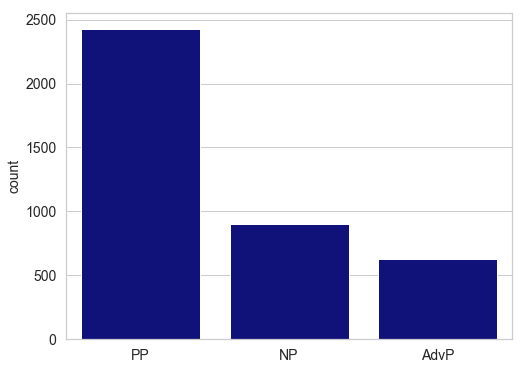

,count
PP,2429
NP,902
AdvP,630


In [3]:
phrase_type = A.search('''

phrase function=Time
/with/
    word language=Hebrew
/-/

''', shallow=True, silent=True)

print(len(phrase_type), 'time phrases found...\n\n')

p_type_count = collections.Counter()
for phrase in phrase_type:
    p_type_count[F.typ.v(phrase)] += 1
    
p_type_count = barplot_counts(p_type_count, save='paper_data/short_study/phrase_types.png')
    
display(p_type_count)

p_type_count.to_csv('paper_data/short_study/phrase_types.csv')

Below is a strip plot illustrating the distribution of the time phrase by chapter in the Hebrew Bible.

In [49]:
strip_data = []
covered_chapters = set()
bookboundaries = {}

twelve = ('Hosea', 'Joel', 'Amos', 'Obadiah',
          'Jonah', 'Micah', 'Nahum', 'Habakkuk',
          'Zephaniah', 'Haggai', 'Zechariah',
          'Malachi')
megilloth = ('Ruth', 'Lamentations', 'Ecclesiastes', 'Esther', 'Song_of_songs')
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
for book in twelve: book_map[book] = 'Twelve'
for book in megilloth: book_map[book] = 'Megilloth'
for book in ('Ezra', 'Nehemiah', 'Daniel'): book_map[book] = 'Daniel-Neh'

this_book = None
for tp in sorted(phrase_type):
    
    chapter_node = L.u(tp, 'chapter')[0]
    book, chapter, verse = T.sectionFromNode(tp)
    this_book = book_map.get(book, book)
    covered_chapters.add(chapter_node)
    chapter_label = len(covered_chapters)
        
    if this_book not in bookboundaries:
        bookboundaries[this_book] = chapter_label
    
    strip_data.append(chapter_label)
    

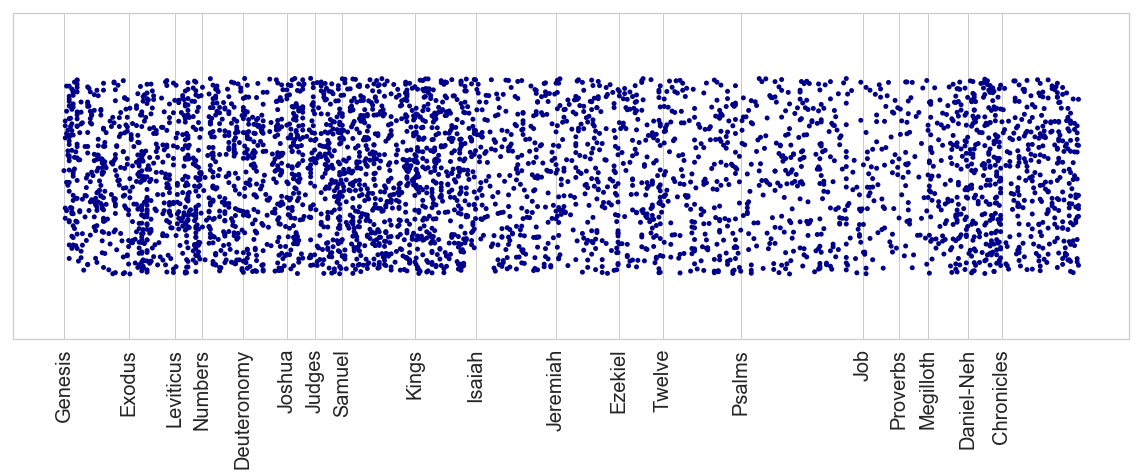

In [67]:
plt.figure(figsize=(20, 6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue')
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.savefig('paper_data/short_study/tp_jitter.png', dpi=300, bbox_inches='tight')
plt.show()

A decision is made to exclude adverb phrases with particle heads, in line with Haspelmath 1997. Below I show which adverbs are excluded and included.

In [398]:
advb_count = collections.Counter()

excluded = set()

advb_ph = A.search('''

phrase function=Time typ=AdvP
    <nhead- word sp#subs language=Hebrew

''')

for ph, nhead in advb_ph:
    if F.lex.v(nhead) != 'JWMM':
        excluded.add(F.lex_utf8.v(nhead))
    
print(' ,'.join(excluded))

  1.39s 463 results
רביעי ,אחרון ,אז ,אך ,עתה


In [397]:
advb_count = collections.Counter()

included = set()

advb_ph = A.search('''

phrase function=Time typ=AdvP
    <nhead- word sp=subs language=Hebrew

''')

for ph, nhead in advb_ph:
    included.add(F.lex_utf8.v(nhead))
    
print(' ,'.join(included))

  1.20s 194 results
תמיד ,טרם ,שׁלשׁום ,בקר ,אמשׁ ,קדם ,אתמול ,יום ,תמול ,נצח ,רגע ,מחר ,אחר ,לילה


### The Problem of Test Clusters

In a previous study on noun semantics, I applied automated semantic analysis to the top 199 occurring nouns in the corpus. If we take the surface form of the time adverbials, do we have enough data to develop rudimentary clusters?

I have decided to initially focus on PP and NP types and treat AdvP separately on a later occasion (following Haspelmath 1997).

For certain values we fill in placeholder to create more grouping:
* cardinal number lexemes are replaced by: `C`

In [325]:
time_phrases = A.search('''

phrase function=Time

/with/
typ=NP
    word language=Hebrew

/or/
typ=PP
    <nhead- word pdp=subs language=Hebrew

/or/
typ=AdvP 
    <nhead- word language=Hebrew
    /with/
    sp=subs
    /or/
    lex=JWMM
    /-/
/-/
''', shallow=True)

tp_tokens = collections.Counter()
tp_rawtokens = collections.Counter()
token2phrase = collections.defaultdict(list)

def tokenizeTP(wordnode):
    '''Builds tokens for time phrase words based on my criteria.'''
    if F.ls.v(wordnode) == 'card':
        return 'מ׳'
    else:
        return F.g_cons_utf8.v(wordnode) or 'ה'
    
for tp in time_phrases:
    # develop a surface token without vocalization / accents
    token = '.'.join(tokenizeTP(w) for w in L.d(tp, 'word'))
    raw_token = '.'.join(F.g_cons_utf8.v(w) or 'ה' for w in L.d(tp, 'word'))
    tp_tokens[token] += 1
    tp_rawtokens[raw_token] += 1
    token2phrase[token].append(tp)
    
print(f'{len(time_phrases)} time phrases counted...')

  0.92s 3378 results
3378 time phrases counted...


#### Raw Token Counts

In [326]:
tp_rawtokens = pd.DataFrame.from_dict(tp_rawtokens, orient='index', columns=['count']).sort_values(ascending=False, by='count')

tp_rawtokens.head(25)

,count
ב.ה.יום.ה.הוא,205
ה.יום,192
ל.עולם,87
ב.ה.בקר,79
עד.ה.יום.ה.זה,73
ב.יום,69
שׁבעת.ימים,66
עד.עולם,53
כל.ה.ימים,44
עד.ה.ערב,42


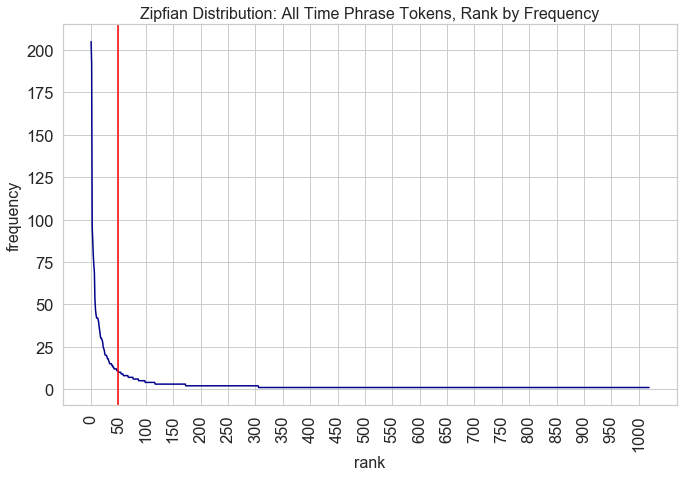

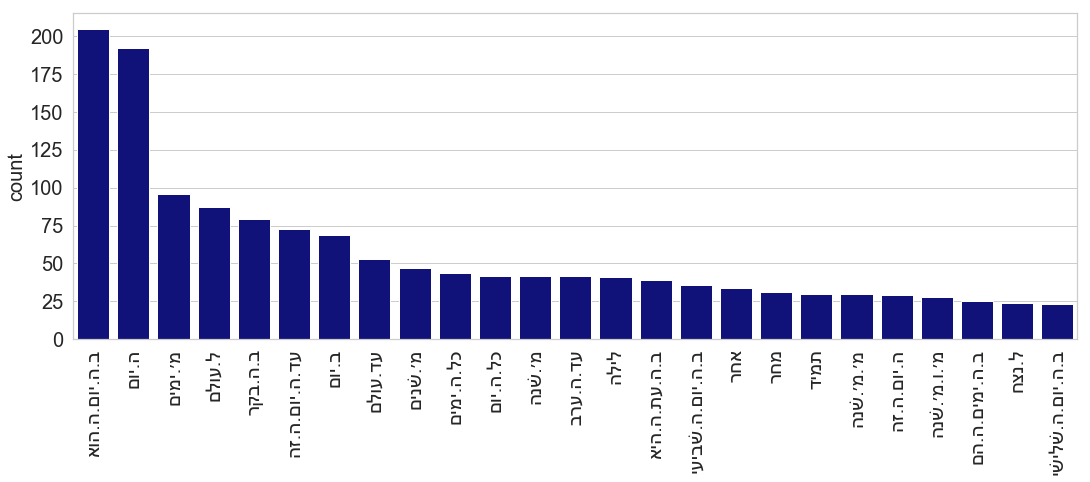

In [327]:
display(HTML(f'<h5>total number of TP tokens: {len(tp_tokens)}</h5>'))
print('\n\n')
plt.figure(figsize=(11, 7))
plt.plot(np.arange(len(tp_tokens)), sorted(tp_tokens.values(), reverse=True), color='darkblue')
plt.xlabel('rank', size=16)
plt.ylabel('frequency', size=16)
plt.xticks(np.arange(0, len(tp_tokens), step=50), rotation='vertical')
plt.axvline(50, color='red')
plt.savefig('paper_data/short_study/zipfian_plot.png', dpi=300, bbox_inches='tight')
plt.title('Zipfian Distribution: All Time Phrase Tokens, Rank by Frequency', size=16)

    
tp_surface_ct = barplot_counts(tp_tokens, 
                               size=(18, 6), 
                               reverse_labels=True, 
                               title='',
                               rotation='vertical', 
                               text_size=20,
                               limit=25,
                               save='paper_data/short_study/bar_tokens.png')

### Examine test-set frequencies

In [328]:
# get number of items with freq >= 10
tp_surface_ct[tp_surface_ct['count'] >= 10].shape

(55, 1)

In [329]:
toptokens = pd.DataFrame(tp_surface_ct[tp_surface_ct['count'] >= 10])
toptokens.to_csv('paper_data/short_study/top_tokens.csv')
toptokens

,count
ב.ה.יום.ה.הוא,205
ה.יום,192
מ׳.ימים,96
ל.עולם,87
ב.ה.בקר,79
עד.ה.יום.ה.זה,73
ב.יום,69
עד.עולם,53
מ׳.שׁנים,47
כל.ה.ימים,44


In [330]:
toptokens.sum() # number of potential samples

count    1867
dtype: int64

There are 55 tokens with a frequency >= 10. This may be a good set to begin with. Let's look at those with 5 occurrences...

### Determine Set Size with Requirements

The set should contain predicates in each case. How much does that shrink the pool?

In [331]:
token2count = collections.Counter()

for token in toptokens.index:
    
    limit = A.search(f'''

clause
    {token}
    phrase function=Pred|PreS|PreO
    
    ''', sets=token2phrase, silent=True)
    
    token2count[token] += len(limit)
    
tokencounts = pd.DataFrame.from_dict(token2count, orient='index', columns=['count']).sort_values(ascending=False, by='count')

tokencounts

,count
ב.ה.יום.ה.הוא,197
ה.יום,113
מ׳.ימים,90
ב.ה.בקר,74
ל.עולם,73
עד.ה.יום.ה.זה,64
ב.יום,55
מ׳.שׁנים,44
עד.עולם,43
עד.ה.ערב,42


In [332]:
tokencounts.shape

(55, 1)

After checking for predicates, the remaining data is sufficient to continue on with the analysis.

## Statistical Analysis of Tokens

Following a similar strategy to my work on nouns, we apply here a statistical analysis of the surface forms above. Specifically, we are looking for collocation tendencies in two areas: the first is with certain verb lexemes, and the second is with verb conjugations. The result will be two tables that we will clean and prepare for PCA cluster analysis.

In [319]:
def get_grandma(clause_atom):
    '''
    Recursively climbs up a qatal clause chain.
    Stops upon identifying either wayyiqtol
    or a yiqtol|impv grand(mother).
    '''
    this_verb = next((F.vt.v(w) for w in L.d(clause_atom) if F.pdp.v(w)=='verb'), '')
    mother = next((m for m in E.mother.f(clause_atom)), 0)
    mom_verb = next((F.vt.v(w) for w in L.d(mother) if F.pdp.v(w)=='verb'), '')    
    
    if mom_verb in {'wayq', 'impf', 'impv'}:
        return mom_verb
    elif not mother:
        return this_verb
    else:
        return get_grandma(mother)

def filter_tense(verb_node):
    '''
    Identifies and tags weqetal verbs.
    For all other, returns tense value.
    Uses the mother clause from the ETCBC and 
    looks for immediately preceding waw.
    '''
    if F.vt.v(verb_node) == 'perf' and F.lex.v(verb_node-1) == 'W':
        # check mother
        clause = L.u(verb_node, 'clause_atom')[0]
        qatal_ancestor = get_grandma(clause)
        if qatal_ancestor in {'impf','impv'}:
            return 'weqt'
        else:
            return F.vt.v(verb_node)
    return F.vt.v(verb_node)

def disambigUTF8(wordnode):
    '''
    Adds modified ETCBC disambiguators 
    to UTF8 lexical forms.
    '''
    letters = [letter for letter in F.lex.v(wordnode)]
    gloss_number = letters.count('=') + 1 if {'[', '/'}&set(letters) else '' # count = (etcbc disambiguator)
    wordtype = 'n' if '/' in letters else 'v' if '[' in letters else ''
    utf8 = F.lex_utf8.v(wordnode)
    disambigs = [dis for dis in [utf8, wordtype+str(gloss_number)] if dis] # remove null strings (e.g. in cases of preps)
    return '.'.join(disambigs)

def tag_verb(verb_node):
    '''
    Constructs a stem+lemma verb token.
    '''
    verb_stem = F.vs.v(verb_node)
    verb_lex = disambigUTF8(verb_node)
    return f'{verb_lex}.{verb_stem}'

In [333]:
raw_lex_counts = collections.defaultdict(lambda: collections.Counter())
raw_conj_counts = collections.defaultdict(lambda: collections.Counter())
basis2lex = collections.defaultdict()

token2lex2results = collections.defaultdict(lambda: collections.defaultdict(list))
token2conj2results = collections.defaultdict(lambda: collections.defaultdict(list))

tp_pattern = '''

clause
    {}
    phrase function=Pred|PreS|PreO
        word pdp=verb
'''

for token in toptokens.index:
    
    results = A.search(tp_pattern.format(token), sets=token2phrase, silent=True)
    print(f'{token}\tresults: {len(results)}')
    
    for result in results:
        clause, tphrase, pphrase, verb = result
        verb_tag = tag_verb(verb)
        verb_conj = filter_tense(verb)
        raw_lex_counts[token][verb_tag] += 1
        raw_conj_counts[token][verb_conj] += 1
        basis2lex[verb_tag] = L.u(verb, 'lex')[0]
        token2lex2results[token][verb_tag].append(result) 
        token2conj2results[token][verb_conj].append(result) 
         
lex_counts = pd.DataFrame(raw_lex_counts).fillna(0)
conj_counts = pd.DataFrame(raw_conj_counts).fillna(0)

display(lex_counts.head())
display(conj_counts.head())

ב.ה.יום.ה.הוא	results: 197
ה.יום	results: 113
מ׳.ימים	results: 90
ל.עולם	results: 73
ב.ה.בקר	results: 74
עד.ה.יום.ה.זה	results: 64
ב.יום	results: 55
עד.עולם	results: 43
מ׳.שׁנים	results: 44
כל.ה.ימים	results: 37
כל.ה.יום	results: 26
מ׳.שׁנה	results: 40
עד.ה.ערב	results: 42
לילה	results: 30
ב.ה.עת.ה.היא	results: 36
ב.ה.יום.ה.שׁביעי	results: 32
אחר	results: 31
מחר	results: 25
תמיד	results: 19
מ׳.מ׳.שׁנה	results: 29
ה.יום.ה.זה	results: 25
מ׳.ו.מ׳.שׁנה	results: 28
ב.ה.ימים.ה.הם	results: 18
ל.נצח	results: 24
ב.ה.יום.ה.שׁלישׁי	results: 20
ה.לילה	results: 18
מ.מחרת	results: 19
יומם	results: 13
ב.ה.ערב	results: 17
ב.ה.עת.ה.הוא	results: 17
ימים.רבים	results: 17
יומם.ו.לילה	results: 15
מ׳.חדשׁים	results: 13
ב.ה.לילה	results: 10
ב.ה.לילה.ה.הוא	results: 14
ל.עלם	results: 11
ל.פנים	results: 8
ב.מ׳.ל.ה.חדשׁ	results: 13
ב.ה.יום.ה.שׁמיני	results: 12
ב.עצם.ה.יום.ה.זה	results: 14
ב.ימיו	results: 13
ב.יום.ה.שׁבת	results: 8
ב.אחרית.ה.ימים	results: 12
ב.ה.בקר.ב.ה.בקר	results: 11
כל.ה.לילה	results: 9
ל.עד	r

,ב.ה.יום.ה.הוא,ה.יום,מ׳.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,מ׳.שׁנים,כל.ה.ימים,...,ל.עד,ב.כל.עת,עד.בקר,ב.ה.צהרים,עד.ה.בקר,ב.ה.יום.ה.שׁני,מ.יום,ב.עת,בין.ה.ערבים,ב.יום.מ׳
אבד.v1.piel,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
אבד.v1.qal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
אבל.v1.hif,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
אבל.v1.hit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
אהב.v1.qal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ב.ה.יום.ה.הוא,ה.יום,מ׳.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,מ׳.שׁנים,כל.ה.ימים,...,ל.עד,ב.כל.עת,עד.בקר,ב.ה.צהרים,עד.ה.בקר,ב.ה.יום.ה.שׁני,מ.יום,ב.עת,בין.ה.ערבים,ב.יום.מ׳
impf,56.0,25.0,40.0,48.0,10,3.0,18.0,22.0,7.0,8.0,...,9.0,4.0,8.0,5.0,4.0,1.0,0.0,1.0,7.0,4.0
impv,0.0,6.0,4.0,3.0,8,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
infa,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
infc,1.0,8.0,1.0,6.0,3,1.0,2.0,5.0,0.0,10.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
perf,44.0,58.0,10.0,9.0,2,24.0,22.0,5.0,20.0,7.0,...,0.0,2.0,1.0,1.0,0.0,2.0,8.0,3.0,0.0,0.0


In [334]:
conj_counts

,ב.ה.יום.ה.הוא,ה.יום,מ׳.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,מ׳.שׁנים,כל.ה.ימים,...,ל.עד,ב.כל.עת,עד.בקר,ב.ה.צהרים,עד.ה.בקר,ב.ה.יום.ה.שׁני,מ.יום,ב.עת,בין.ה.ערבים,ב.יום.מ׳
impf,56.0,25.0,40.0,48.0,10,3.0,18.0,22.0,7.0,8.0,...,9.0,4.0,8.0,5.0,4.0,1.0,0.0,1.0,7.0,4.0
impv,0.0,6.0,4.0,3.0,8,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
infa,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
infc,1.0,8.0,1.0,6.0,3,1.0,2.0,5.0,0.0,10.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
perf,44.0,58.0,10.0,9.0,2,24.0,22.0,5.0,20.0,7.0,...,0.0,2.0,1.0,1.0,0.0,2.0,8.0,3.0,0.0,0.0
wayq,65.0,12.0,19.0,2.0,43,36.0,8.0,2.0,15.0,4.0,...,0.0,0.0,1.0,2.0,3.0,6.0,1.0,3.0,1.0,2.0
weqt,31.0,4.0,16.0,5.0,7,0.0,3.0,8.0,2.0,8.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0


#### Dimensions of the Data and Adjustments

In [335]:
lex_counts.shape

(378, 55)

In [336]:
conj_counts.shape

(7, 55)

In [337]:
pd.DataFrame(lex_counts[['ב.ה.יום.ה.הוא','ה.יום', 'מ׳.ימים']].sort_values(by='ב.ה.יום.ה.הוא', ascending=False).head(10)).to_csv('paper_data/short_study/raw_ex_lex.csv')

In [338]:
pd.DataFrame(conj_counts[['ב.ה.יום.ה.הוא','ה.יום', 'מ׳.ימים']].sort_values(by='ב.ה.יום.ה.הוא', ascending=False).head(10)).to_csv('paper_data/short_study/raw_ex_conj.csv')

Number of verbs only observed once:

In [339]:
hapax = lex_counts.sum(1)[lex_counts.sum(1) == 1]
hapax.shape

(191,)

Drop those verbs...

In [340]:
lex_data = lex_counts.drop(hapax.index)

#### Size of the New Lex Dataset

In [341]:
lex_data.shape

(187, 55)

Check to see whether any TPs have been eliminated...

In [342]:
lex_data.sum().min()

5.0

The minimum count in the dataset is 5, not zero. That is what is wanted.

#### Fisher's Exact Adjustments

In [343]:
lextransf = apply_fishers(lex_data)
conjtransf = apply_fishers(conj_counts)

In [344]:
lextransf.head()

,ב.ה.יום.ה.הוא,ה.יום,מ׳.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,מ׳.שׁנים,כל.ה.ימים,...,ל.עד,ב.כל.עת,עד.בקר,ב.ה.צהרים,עד.ה.בקר,ב.ה.יום.ה.שׁני,מ.יום,ב.עת,בין.ה.ערבים,ב.יום.מ׳
אבד.v1.piel,0.000000,0.000000,0.000000,0.000000,0.000000,1.084799,0.00000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.995011
אבד.v1.qal,0.386136,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,...,1.841053,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
אבל.v1.hit,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1.142023,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
אכל.v1.nif,0.315009,0.000000,0.560228,0.000000,0.000000,0.000000,0.81572,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
אכל.v1.qal,-0.245768,1.928839,2.840506,-0.402251,0.189817,0.000000,0.00000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.758613,0.0,0.0,0.0,0.0,0.717178,0.859071


In [345]:
conjtransf

,ב.ה.יום.ה.הוא,ה.יום,מ׳.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,מ׳.שׁנים,כל.ה.ימים,...,ל.עד,ב.כל.עת,עד.בקר,ב.ה.צהרים,עד.ה.בקר,ב.ה.יום.ה.שׁני,מ.יום,ב.עת,בין.ה.ערבים,ב.יום.מ׳
impf,-0.385874,-1.460110,2.172960,9.316967,-3.332801,-6.610409,0.114177,2.171993,-1.512748,-0.552277,...,4.586489,0.577570,2.697884,0.477762,0.290746,-0.539776,-1.190520,-0.349190,1.890258,0.326148
impv,-2.354523,0.898497,0.503577,0.341976,3.129798,-0.590226,0.177213,0.000000,-0.198805,-0.205501,...,0.000000,0.691268,0.000000,0.000000,2.669196,0.000000,0.000000,0.000000,0.000000,0.000000
infa,0.000000,0.000000,0.000000,0.000000,1.036400,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
infc,-2.504844,0.885830,-0.754696,0.932224,0.000000,-0.288265,0.000000,1.555965,-0.590226,6.045915,...,0.000000,0.000000,0.000000,0.434276,0.000000,0.000000,0.000000,0.547560,0.467386,0.504804
perf,-0.648594,8.577207,-3.321242,-2.233116,-7.093955,1.384600,1.564552,-1.481434,2.312235,-0.348863,...,-0.911291,0.000000,-0.328788,-0.513264,-1.142013,0.000000,3.849850,0.359512,-1.142013,-0.911291
wayq,1.508722,-4.652613,-0.570589,-7.118911,8.220012,6.511390,-1.367775,-3.481061,0.526355,-1.443525,...,-0.909604,-0.924411,-0.327162,-0.132234,0.136350,1.875064,-0.338019,0.352528,-0.327162,0.000000
weqt,2.648174,-1.560917,2.096770,-0.168902,-0.000000,-2.491500,-0.322582,1.265925,-0.370286,1.765823,...,0.000000,0.265727,-0.212959,0.565093,-0.212959,0.000000,0.000000,0.000000,-0.000000,0.697753


##### Fisher's Exploration

In [346]:
lextransf.max(1).sort_values(ascending=False).head()

טמא.v1.qal     49.318918
שׁכם.v1.hif    35.953769
מלך.v1.qal     19.299980
סגר.v1.hif     11.028013
יתר.v1.hif      9.078304
dtype: float64

In [347]:
pd.DataFrame(conjtransf.max().sort_values(ascending=False)).head(10)

,0
מ.מחרת,11.083370
ל.עולם,9.316967
עד.ה.ערב,9.255398
ה.יום,8.577207
ב.ה.בקר,8.220012
ל.נצח,6.824066
עד.ה.יום.ה.זה,6.511390
כל.ה.ימים,6.045915
מ׳.ו.מ׳.שׁנה,5.454195
ב.ה.לילה.ה.הוא,5.245646


In [348]:
conj_counts['מ.מחרת'].sort_values(ascending=False)

wayq    19.0
weqt     0.0
perf     0.0
infc     0.0
infa     0.0
impv     0.0
impf     0.0
Name: מ.מחרת, dtype: float64

In [349]:
conjtransf['מ.מחרת'].sort_values(ascending=False)

wayq    11.083370
infc     0.000000
infa     0.000000
impv     0.000000
weqt    -0.606776
perf    -2.207469
impf    -2.783070
Name: מ.מחרת, dtype: float64

In [350]:
conj_counts['ל.עולם'].sort_values(ascending=False)

impf    48.0
perf     9.0
infc     6.0
weqt     5.0
impv     3.0
wayq     2.0
infa     0.0
Name: ל.עולם, dtype: float64

In [351]:
conjtransf['ל.עולם'].sort_values(ascending=False)

impf    9.316967
infc    0.932224
impv    0.341976
infa    0.000000
weqt   -0.168902
perf   -2.233116
wayq   -7.118911
Name: ל.עולם, dtype: float64

# PCA Analyses

## Clustering with Verb Lexeme Attraction Scores

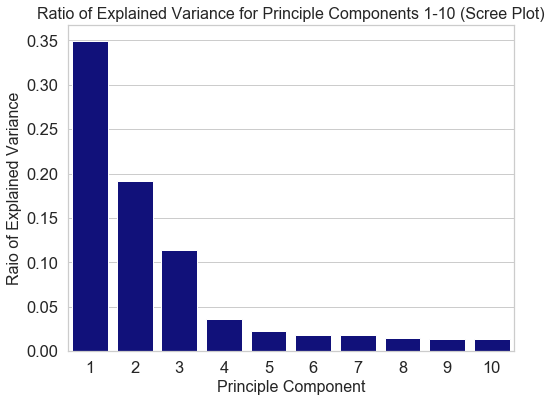

In [352]:
pca = PCA(10)
lex_fit = pca.fit(lextransf.T.values)
pca_lexs = lex_fit.transform(lextransf.T.values)

lexloadings = lex_fit.components_.T * np.sqrt(lex_fit.explained_variance_)
lexloadings = pd.DataFrame(lexloadings.T, index=np.arange(10)+1, columns=lextransf.index)


plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=lex_fit.explained_variance_ratio_[:10], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=16)
plt.show()

### PC1 and PC2

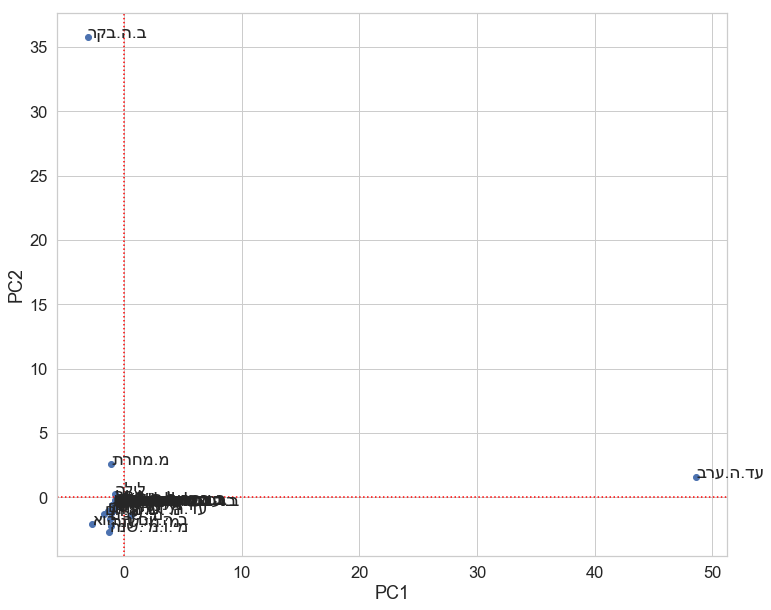

In [353]:
plot_PCA(pca_lexs, components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

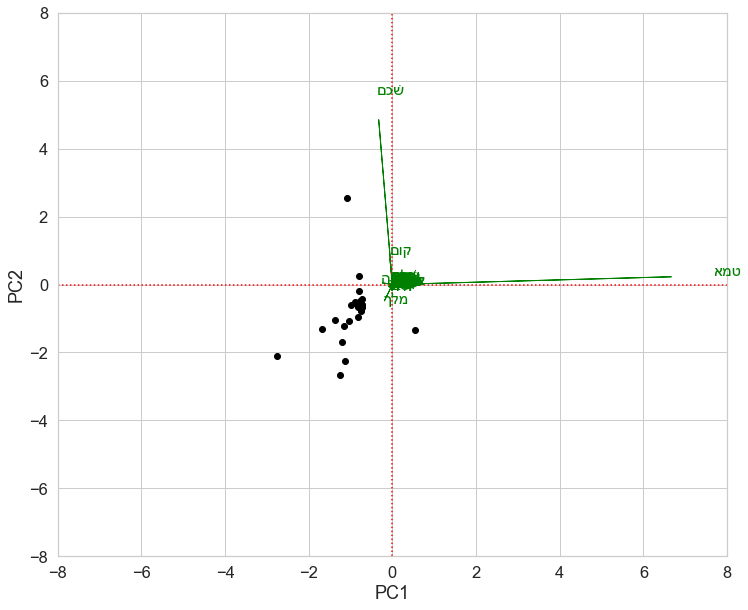

In [354]:
x, y = (pca_lexs[:,0], pca_lexs[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-8, 8, -8, 8)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings:
    x, y = lexloadings[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

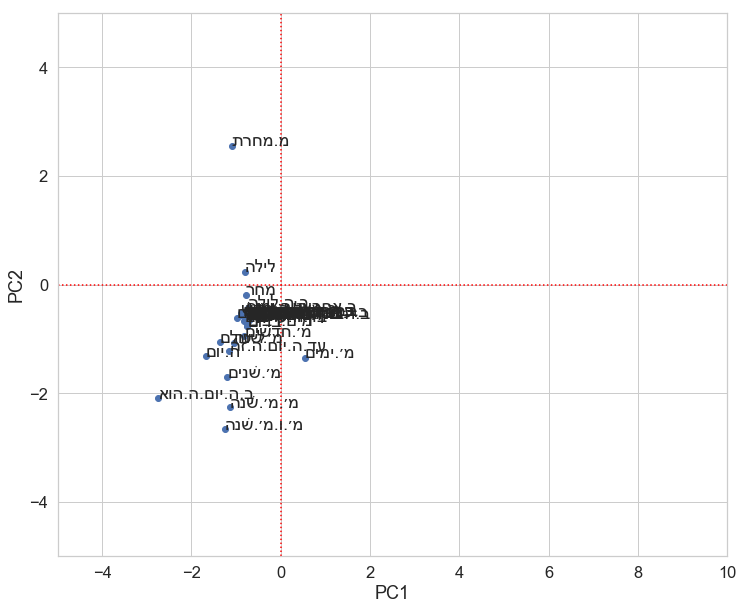

In [355]:
plot_PCA(pca_lexs, zoom=((-5, 10, -5, 5)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

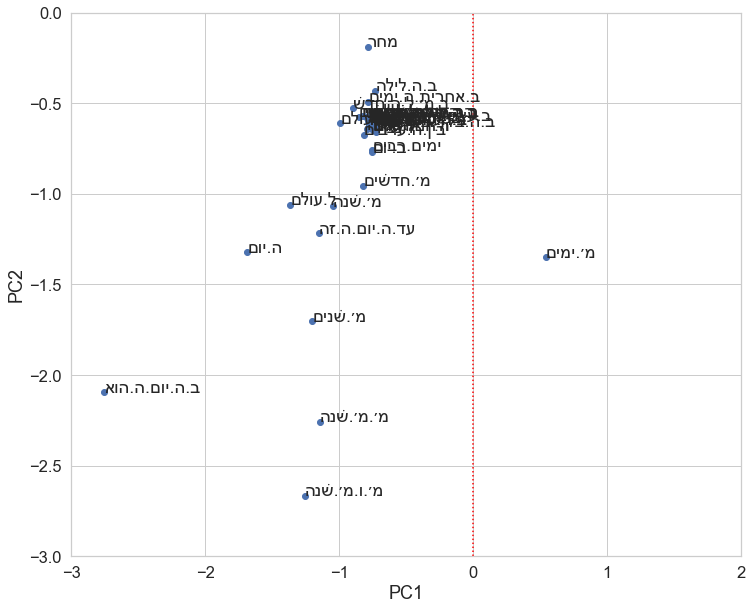

In [356]:
plot_PCA(pca_lexs, zoom=((-3, 2, -3, 0)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

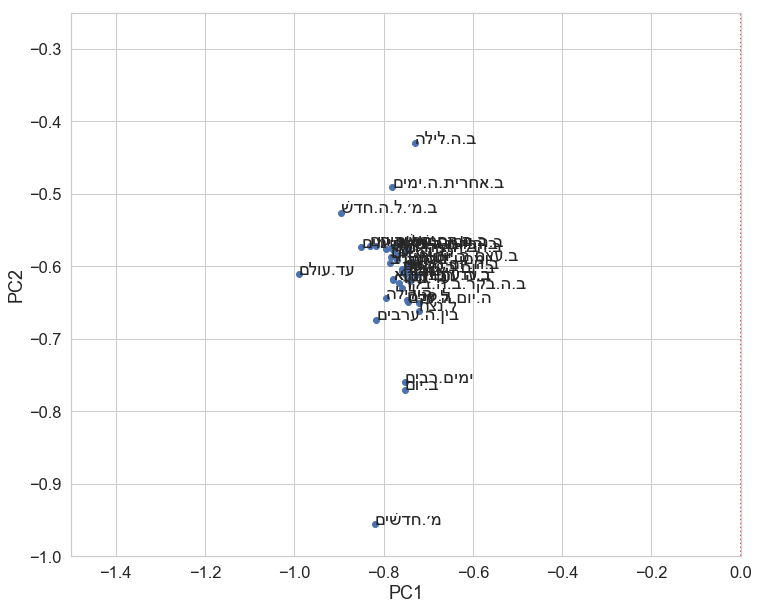

In [357]:
plot_PCA(pca_lexs, zoom=((-1.5, 0, -1, -0.25)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

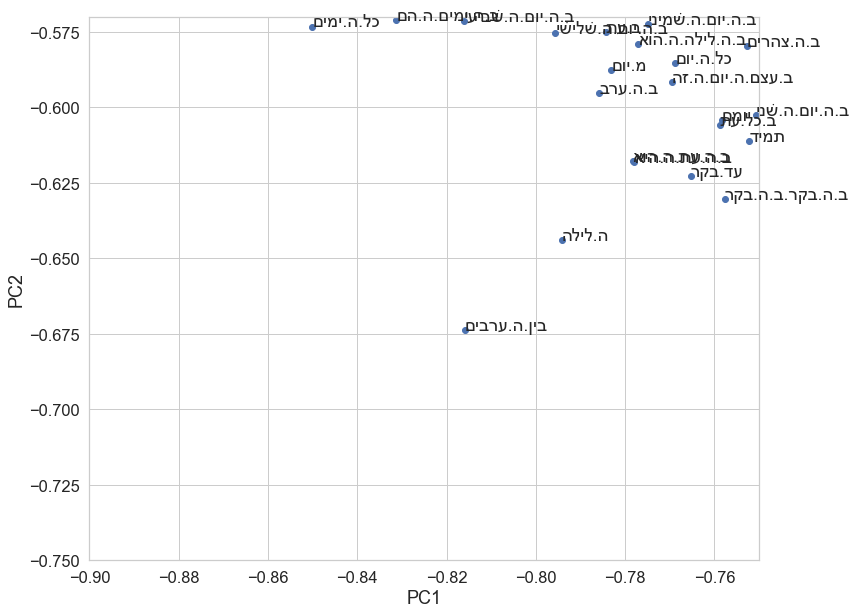

In [358]:
plot_PCA(pca_lexs, zoom=((-0.90, -0.75, -.75, -0.57)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

#### Loading Scores and Contexts

What influences the first or second principle components?

In [359]:
lexloadings.loc[1].sort_values(ascending=False).head(10)

טמא.v1.qal     6.664755
צום.v1.qal     0.251753
לקט.v1.piel    0.160320
נפל.v1.qal     0.135171
סגר.v1.nif     0.125242
בכה.v1.qal     0.116445
סגר.v1.hif     0.018216
אכל.v1.qal     0.014864
עשׂה.v1.nif    0.005462
חגג.v1.qal     0.005462
Name: 1, dtype: float64

In [360]:
lexloadings.loc[2].sort_values(ascending=False).head(15)

שׁכם.v1.hif     4.851388
קום.v1.qal      0.769089
טמא.v1.qal      0.227319
פנה.v1.qal      0.136406
שׁמר.v1.nif     0.133321
מות.v1.hif      0.132465
שׁלח.v1.piel    0.111010
בין.v1.hit      0.108065
זרע.v1.qal      0.098932
שׁמע.v1.qal     0.071903
היה.v1.qal      0.049283
אמר.v1.qal      0.043873
נגד.v1.hif      0.041406
דבר.v1.piel     0.021303
עלה.v1.qal      0.014631
Name: 2, dtype: float64

In [361]:
lexloadings.loc[2].sort_values().head(15)

מלך.v1.qal    -0.482660
חיה.v1.qal    -0.142887
ישׁב.v1.qal   -0.128899
נתן.v1.qal    -0.080986
עבד.v1.qal    -0.070486
קרא.v1.qal    -0.068782
עשׂה.v1.qal   -0.063520
סגר.v1.hif    -0.053898
שׁפט.v1.qal   -0.053754
ידע.v1.qal    -0.037239
שׁקט.v1.qal   -0.028695
לין.v1.qal    -0.027613
צוה.v1.piel   -0.027057
פשׁע.v1.qal   -0.026301
בוא.v1.qal    -0.025382
Name: 2, dtype: float64

### PC2 and PC3

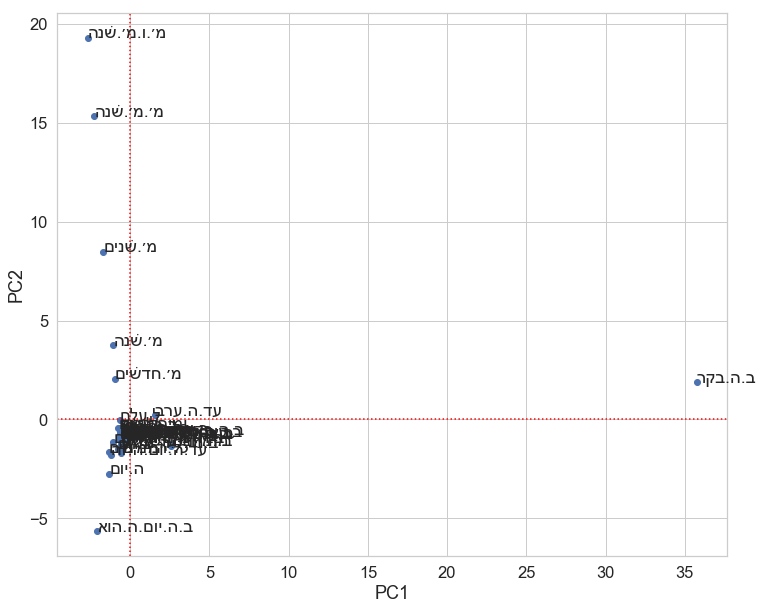

In [362]:
plot_PCA(pca_lexs, components=(pca_lexs[:,1], pca_lexs[:,2]), annoTags=[reverse_hb(token) for token in lextransf.columns])

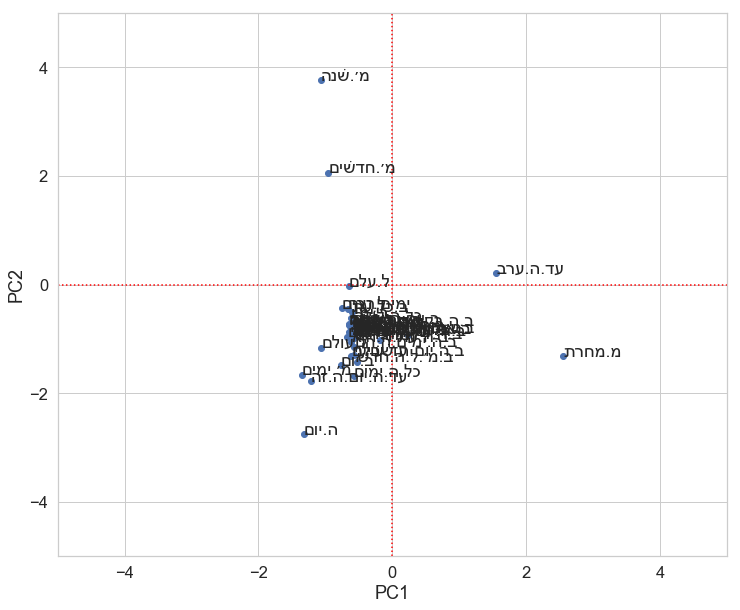

In [363]:
plot_PCA(pca_lexs, zoom=((-5, 5, -5, 5)), components=(pca_lexs[:,1], pca_lexs[:,2]), annoTags=[reverse_hb(token) for token in lextransf.columns])

In [364]:
lexloadings.loc[3].sort_values(ascending=False).head(15)

מלך.v1.qal     3.508436
חיה.v1.qal     1.064742
עבד.v1.qal     0.480777
שׁכם.v1.hif    0.370790
שׁפט.v1.qal    0.326745
בנה.v1.qal     0.129696
שׁקט.v1.qal    0.122663
זרע.v1.qal     0.113953
טמא.v1.qal     0.099396
הלך.v1.hif     0.070358
מרד.v1.qal     0.066146
הלך.v1.hit     0.062069
צור.v1.qal     0.046812
גור.v1.qal     0.046812
בנה.v1.nif     0.044479
Name: 3, dtype: float64

In [365]:
lexloadings.loc[3].sort_values().head(15)

היה.v1.qal    -0.589468
עשׂה.v1.qal   -0.149905
ידע.v1.qal    -0.105748
קרא.v1.qal    -0.086584
ירא.v1.qal    -0.084933
סגר.v1.hif    -0.083173
נתן.v1.qal    -0.081248
זבח.v1.qal    -0.065745
כרת.v1.qal    -0.064265
ישׁע.v1.hif   -0.064100
יצא.v1.qal    -0.063499
עוד.v1.hif    -0.059308
אמר.v1.qal    -0.059213
צוה.v1.piel   -0.059049
אכל.v1.qal    -0.054955
Name: 3, dtype: float64

## PCA Lex without Outliers

In [389]:
lextranfs_out = lextransf.drop(['ב.ה.בקר', 'עד.ה.ערב'], axis=1)

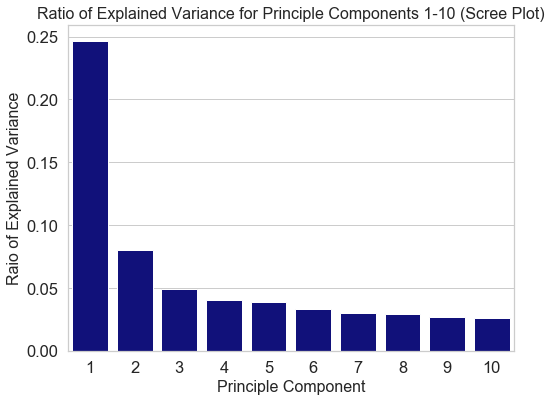

In [367]:
pca = PCA(10)
lex_fit_out = pca.fit(lextranfs_out.T.values)
pca_lexs_out = lex_fit_out.transform(lextranfs_out.T.values)

lexloadings_out = lex_fit_out.components_.T * np.sqrt(lex_fit_out.explained_variance_)
lexloadings_out = pd.DataFrame(lexloadings_out.T, index=np.arange(10)+1, columns=lextranfs_out.index)


plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=lex_fit_out.explained_variance_ratio_[:10], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=16)
plt.show()

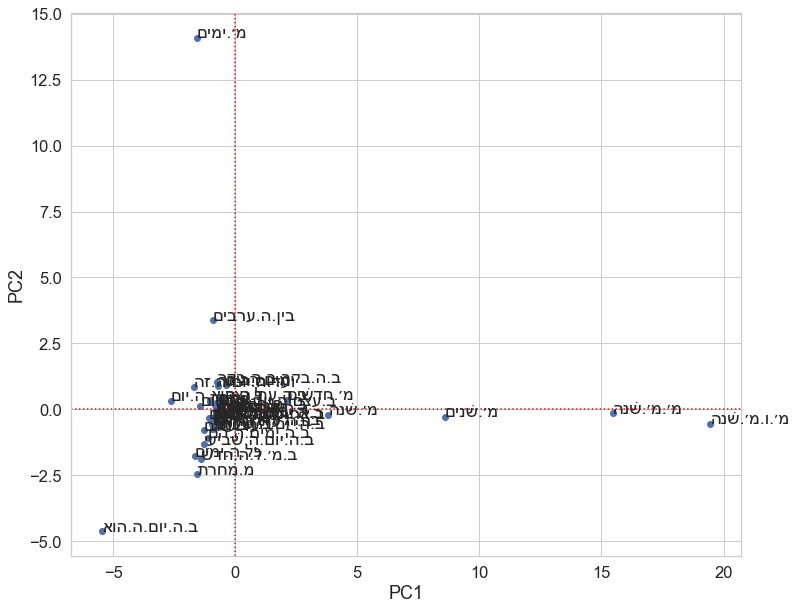

In [368]:
plot_PCA(pca_lexs_out, 
         components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), 
         annoTags=[reverse_hb(token) for token in lextranfs_out.columns],
         save='paper_data/short_study/PCA_lex.png')

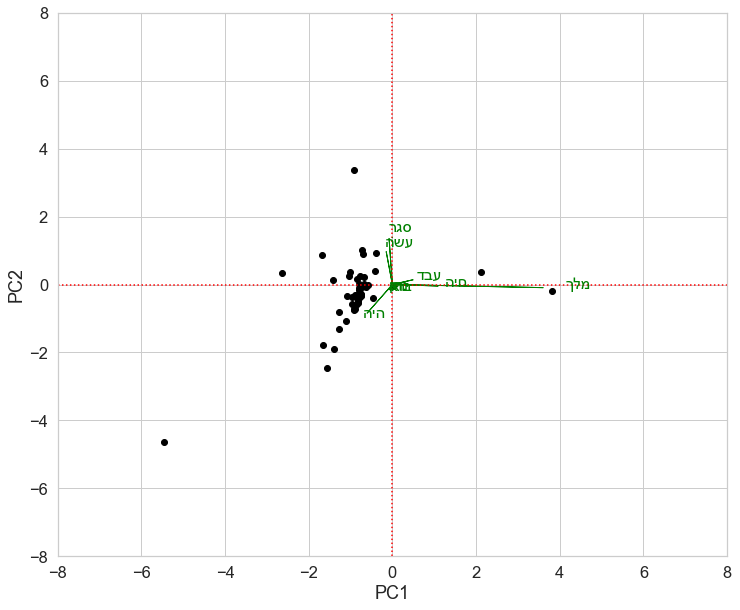

In [369]:
influences = list(lexloadings_out[:2].min().sort_values().head(5).index) + list(lexloadings_out[:2].max().sort_values(ascending=False).head(5).index)

x, y = (pca_lexs_out[:,0], pca_lexs_out[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-8, 8, -8, 8)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings_out:
    
    if lex not in influences:
        continue
    
    x, y = lexloadings_out[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

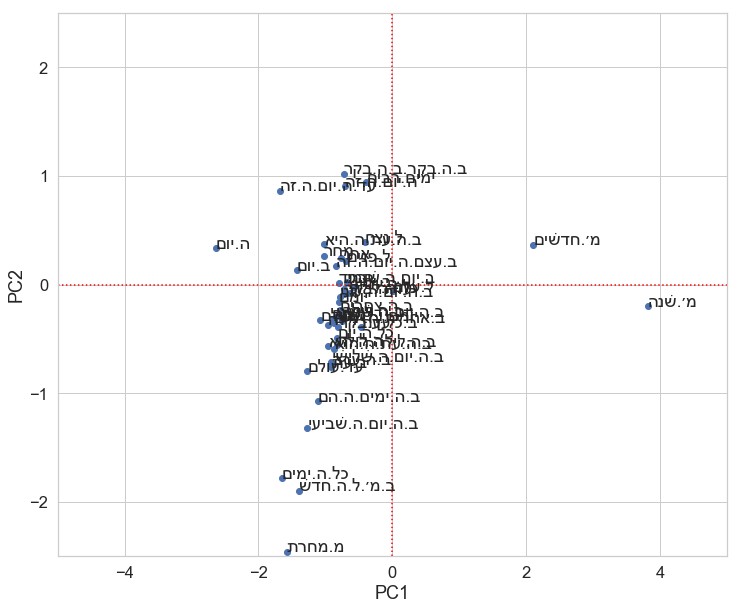

In [370]:
plot_PCA(pca_lexs_out, 
         zoom=((-5, 5, -2.5, 2.5)), 
         components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), 
         annoTags=[reverse_hb(token) for token in lextranfs_out.columns],
         save='paper_data/short_study/PCA_lex_center.png')

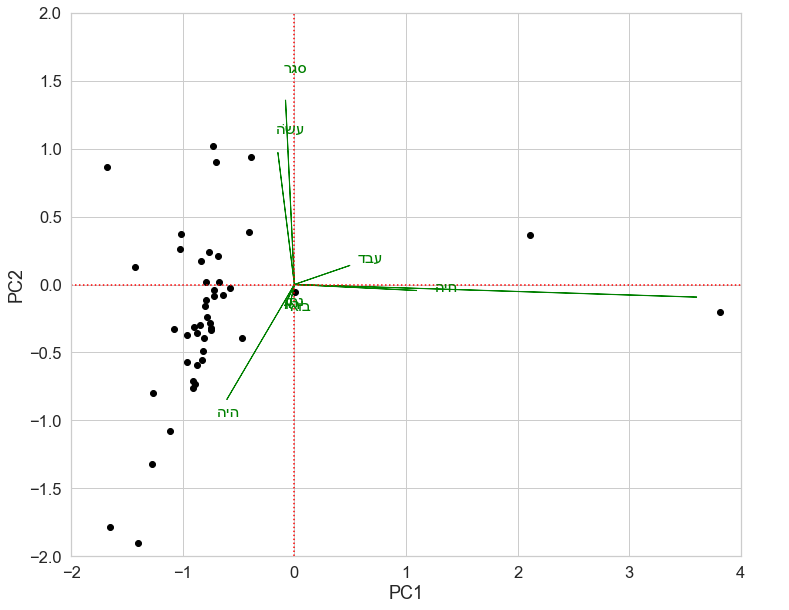

In [371]:
x, y = (pca_lexs_out[:,0], pca_lexs_out[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-2, 4, -2, 2)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings_out:
    
    if lex not in influences:
        continue
    
    x, y = lexloadings_out[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

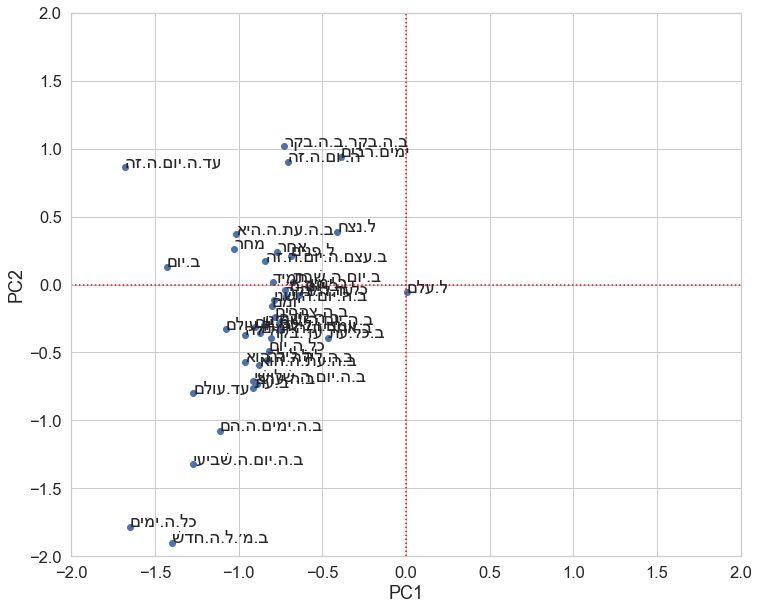

In [372]:
plot_PCA(pca_lexs_out, zoom=((-2, 2, -2, 2)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

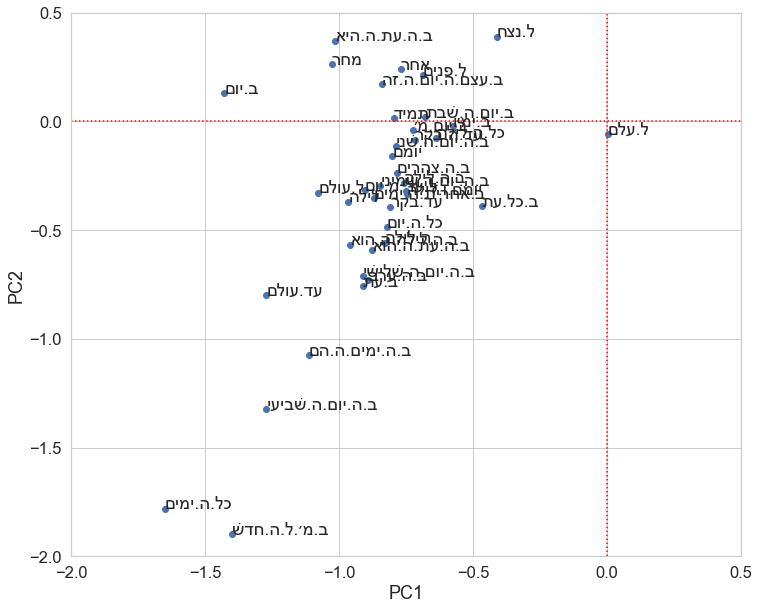

In [373]:
plot_PCA(pca_lexs_out, zoom=((-2, 0.5, -2, 0.5)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

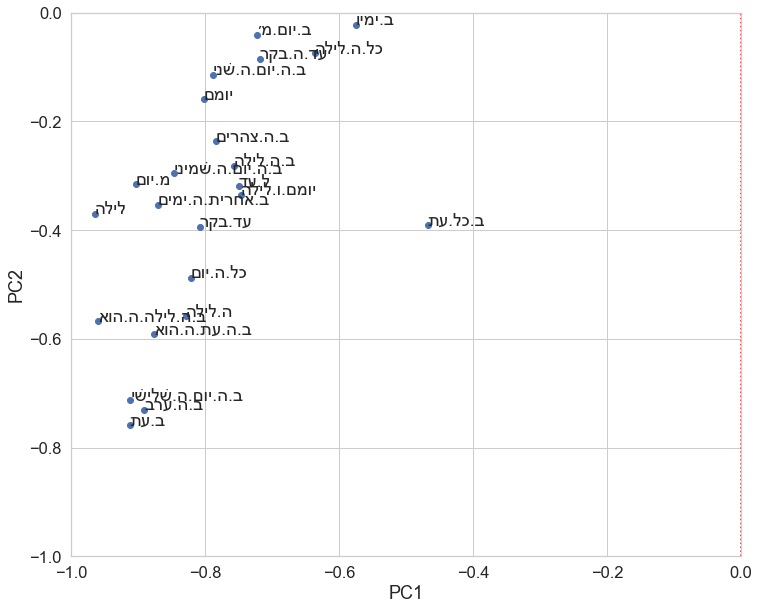

In [374]:
plot_PCA(pca_lexs_out, zoom=((-1, 0, -1, 0)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

In [375]:
lex_loadings_top = pd.DataFrame(lexloadings_out.loc[1].sort_values(ascending=False).head(15))
lex_loadings_top.to_csv('paper_data/short_study/lex_loadings_top.csv')
lex_loadings_top

,1
מלך.v1.qal,3.601719
חיה.v1.qal,1.092504
עבד.v1.qal,0.494153
שׁפט.v1.qal,0.336287
בנה.v1.qal,0.133451
שׁקט.v1.qal,0.126886
זרע.v1.qal,0.109111
הלך.v1.hif,0.073022
מרד.v1.qal,0.069125
הלך.v1.hit,0.064341


In [376]:
lex_loadings_bottom = pd.DataFrame(lexloadings_out.loc[1].sort_values().head(15))
lex_loadings_bottom.to_csv('paper_data/short_study/lex_loadings_bottom.csv')
lex_loadings_bottom

,1
היה.v1.qal,-0.603442
עשׂה.v1.qal,-0.147530
ידע.v1.qal,-0.103141
ירא.v1.qal,-0.084401
קרא.v1.qal,-0.082081
סגר.v1.hif,-0.079352
נתן.v1.qal,-0.075973
זבח.v1.qal,-0.064454
יצא.v1.qal,-0.063504
אמר.v1.qal,-0.063177


#### Interesting Cases

In [377]:
pd.DataFrame(lextransf.loc['בנה.v1.qal'].sort_values(ascending=False)).head(5)

,בנה.v1.qal
ב.ימיו,1.624831
מ׳.מ׳.שׁנה,1.224441
מ׳.שׁנים,1.052793
לילה,0.000000
ב.ה.יום.ה.שׁלישׁי,0.000000


In [378]:
A.show(token2lex2results['C.C.שׁנה']['בנה.v1.qal'])

In [379]:
build = 'בנה.v1.qal'
years = 'C.שׁנים'

A.show(token2lex2results[years][build])

### Clustering with Verb Conjugation (Tense) Attraction Scores

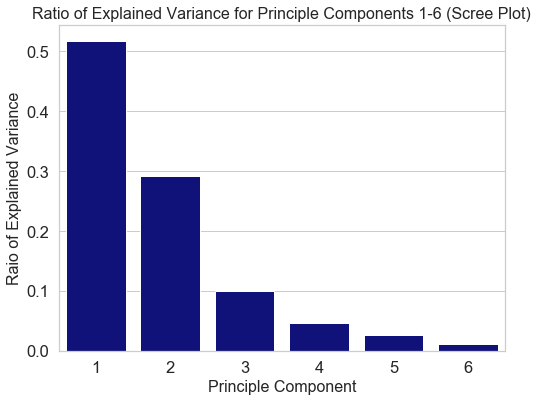

In [380]:
pca = PCA(6)
conj_fit = pca.fit(conjtransf.T.values)
pca_conj = conj_fit.transform(conjtransf.T.values)

conjloadings = conj_fit.components_.T * np.sqrt(conj_fit.explained_variance_)
conjloadings = pd.DataFrame(conjloadings.T, index=np.arange(6)+1, columns=conjtransf.index)


plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(6)+1, y=conj_fit.explained_variance_ratio_[:6], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-6 (Scree Plot)', size=16)
plt.show()

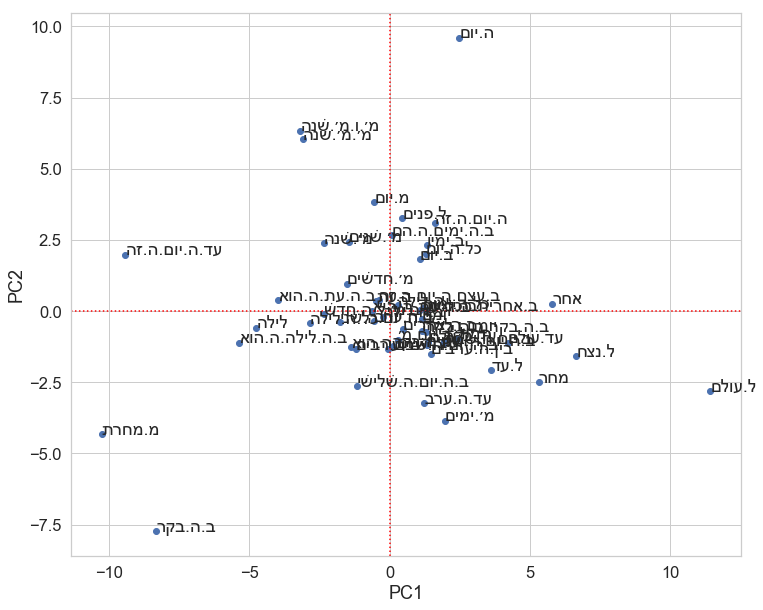

In [381]:
plot_PCA(pca_conj, 
         components=(pca_conj[:,0], pca_conj[:,1]), 
         annoTags=[reverse_hb(token) for token in conjtransf.columns],
         save='paper_data/short_study/PCA_conj.png')

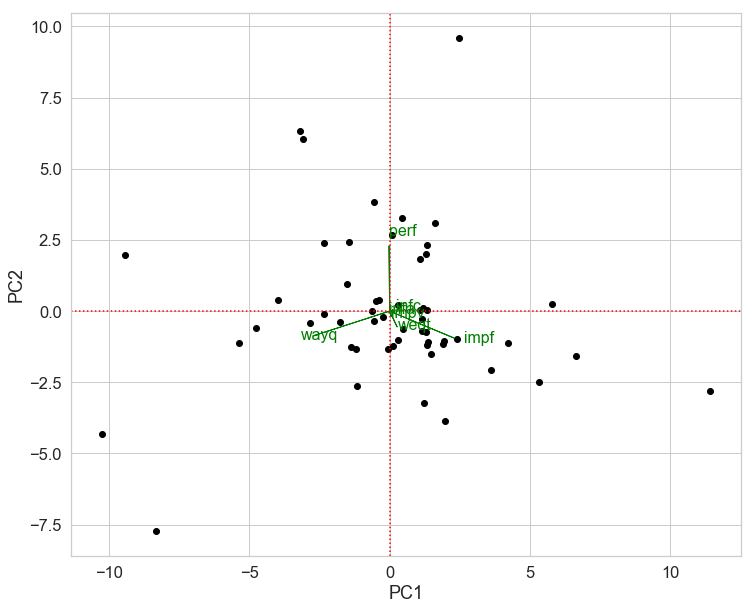

In [382]:
x, y = (pca_conj[:,0], pca_conj[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

for verbconj in conjloadings:
    x, y = conjloadings[verbconj][:2]
    plt.arrow(0, 0, x, y, color='green')
    plt.annotate(verbconj, xy=(x*1.15, y*1.15), color = 'green', size=16)

plt.savefig('paper_data/short_study/PCA_conj_biplot.png', dpi=300, bbox_inches='tight')
        
plt.show()

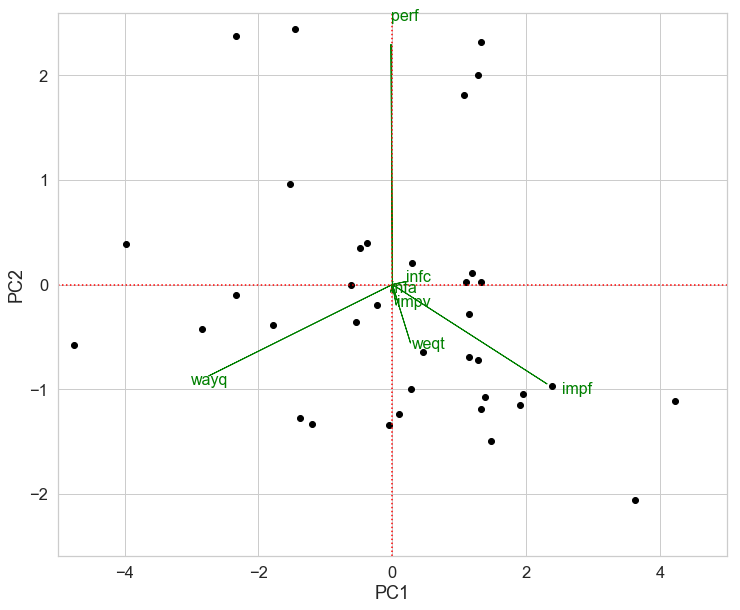

In [392]:
x, y = (pca_conj[:,0], pca_conj[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-5, 5, -2.6, 2.6)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])


for verbconj in conjloadings:
    x, y = conjloadings[verbconj][:2]
    plt.arrow(0, 0, x, y, color='green')
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
    
    plt.annotate(verbconj, xy=(x*1.1, y*1.1), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

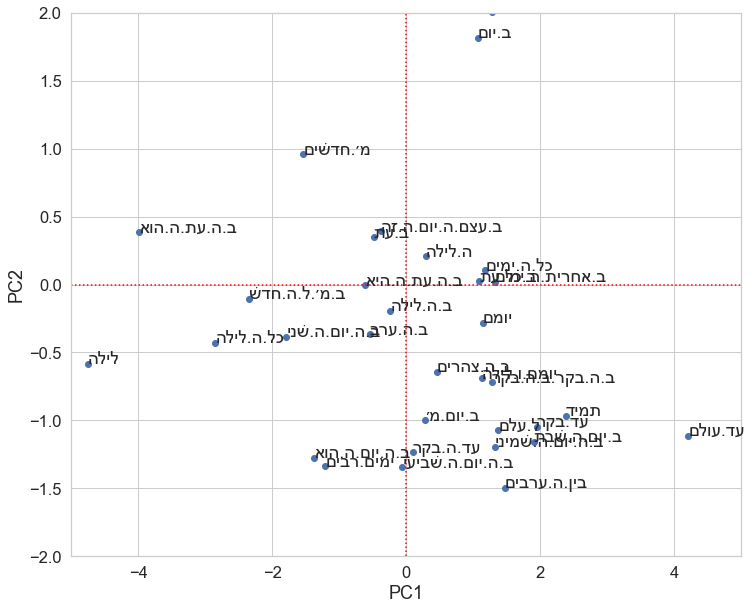

In [393]:
plot_PCA(pca_conj, 
         components=(pca_conj[:,0], pca_conj[:,1]), 
         zoom=((-5, 5, -2, 2)),
         annoTags=[reverse_hb(token) for token in conjtransf.columns],
         save='paper_data/short_study/PCA_conj_center.png')

#### Loading Scores for Conjugations

In [394]:
conjloadings.loc[1].sort_values(ascending=False)

impf    2.307160
weqt    0.269951
infc    0.191024
impv    0.057389
perf   -0.020449
infa   -0.024805
wayq   -2.739730
Name: 1, dtype: float64

In [395]:
conjloadings.loc[2].sort_values(ascending=False)

perf    2.294262
infc    0.026651
infa   -0.070846
impv   -0.194299
weqt   -0.557407
wayq   -0.873598
impf   -0.949970
Name: 2, dtype: float64

#### Interesting Cases

In [387]:
#A.show((ph,) for ph in token2phrase['ב.ה.בקר.ב.ה.בקר'])

# Scratch Code

In [388]:
# all
print('searching total NP time phrases...')
all_np_time = A.search('phrase function=Time typ=NP', shallow=True)

print('searching quantified...')
# group 1, quantified
quant_np = A.search('''

p:phrase function=Time typ=NP
/with/
    word sem_set=quant
/or/
    word nu=pl|du
/or/
    w1:word
    w2:word
    p <head- w1
    p <head- w2
    w1 # w2
    
lex
    w1
    w2
/-/
    
''', shallow=True)

print('searching demonstratives...')
# group 2, demonstrated
demon_np = A.search('''

phrase function=Time typ=NP
/with/
    word pdp=prde
/or/
    =: word pdp=art
/-/

/without/
    word sem_set=quant
/-/
''', shallow=True)

print('searching unmarked...')
# group 3, unmarked
unmarked_np = A.search('''

p:phrase function=Time typ=NP
/with/
    <head- w1:word nu#pl|du
    p =: w1
    p := w1
/-/
''', shallow=True)

found_results = set(quant_np)|set(demon_np)|set(unmarked_np)

print()
print(f'found: {len(found_results)} / {len(all_np_time)}')

searching total NP time phrases...
  0.27s 905 results
searching quantified...
  1.44s 615 results
searching demonstratives...
  0.75s 251 results
searching unmarked...
  1.05s 12 results

found: 875 / 905


In [145]:
groups = {'quant': quant_np, 'demon': demon_np, 'unmarked':unmarked_np}

print('overlap between sets:')
for groupi, resi in groups.items():
    print(groupi)
    for groupj, resj in groups.items():
        
        if groupi == groupj:
            continue
            
        print(f'\t{groupj}: {len(set(resi)&set(resj))}')

overlap between sets:
quant
	demon: 3
	unmarked: 0
demon
	quant: 3
	unmarked: 0
unmarked
	quant: 0
	demon: 0


In [146]:
len(set(all_np_time)-found_results)

30

**NOTES**

These groupings indeed distinguish the most amongst the dataset, though the patterns include a diverse group of searches, putting plurals and quantifieds together, for instance. These should probably be separated out into individual groups. 

In [147]:
A.show(A.search('''

word lex=CNH/
<: word lex=JWM/ nu=pl

'''), end=10)

  0.81s 5 results




**result** *1*





**result** *2*





**result** *3*





**result** *4*





**result** *5*



## Building Test Sets

In [72]:
durative = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time typ=NP
    /without/
        word pdp=prep|prde|advb
    /-/
    /without/
        =: word pdp=art
    /-/
''')

  0.69s 199 results


In [73]:
#A.show(durative, withNodes=True, start=100, end=200)

In [74]:
simultaneous = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time typ=PP
    /without/
        word pdp=prde|advb
    /-/
        <head- word lex=B
''')

  1.11s 414 results


In [75]:
#A.show(simultaneous, withNodes=True, start=0, end=100)

In [76]:
demonstrative = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time
    /without/
        word pdp=advb
    /-/
        word pdp=prde
    
''')

  1.12s 222 results


In [77]:
#A.show(demonstrative, withNodes=True, start=0, end=100)

### Distinguishing from "Purposive Extent"
The atelic time duration is closely related to the "purposive extent," a function illustrated by the construction:

> Sibylle went to Paris for five years. (Haspelmath 1997: 128)

Haspelmath explains further:

> In purposive-extent constructions, the verbal event is not atelic, but the adverbial measures the length of the state resulting from this event. (Haspelmath 1997: 128)

Fuhs describes his method of dealing with this construction:

> In coding, I followed Smith’s suggestion to classify single for-phrases as instances of the durative construction, whereas in double marking, the second phrase was coded as a ‘purpositive extend’ [sic] (Haspelmath 1997: 128; Smith 1997: 114). After manually clearing the set, a total of 671 true instances of the English Durative Adverbial remained, which occurred in clauses in which no other aspect constructions in the periphery were present that could influence the predicate construal. This set was then used for a Collostructional Analysis. (Fuhs 2010: 145)

This procedure is the most vulnerable aspect of Fuhs's study. The purposive extent can occur without the doubling mentioned by Smith. This means that most of these cases would have to be manually sorted, and Fuhs himself would have had to decide whether a time phrase was purposive or not. Smith's criteria for purposive extent presents a circularity issue for Fuhs's manual sorting procedure:

> What triggers the shift [from telic event to atelic] is the incompatibility between the value of the verb constellations (telic) and the adverbials (atelic). (Smith 1997: 113).

Yet, the "compatibility" between the verb and the adverbials is precisely what Fuhs intends to measure. If he had used these notions in his manual sorting, they would might have affected the dataset he obtains.

### From...To Durations (מן...עד)